# 第3週：對ptt美食版「吃到飽」餐廳進行情緒分析
**Author:** 黃天原<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖圖
    + 3.4 正負向情緒分數比例折線圖圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 情緒關鍵字
    + 3.8 與Dcard文集比較

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。

In [45]:
# 安裝會使用到的套件
# %pip install wordcloud

In [46]:
# 確認當前工作目錄
%pwd

'/home/evan19983314/SMA/SMA_2023S/week4_sentiment_analysis'

In [47]:
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

In [48]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
fprop


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集PTT 美食版 Food 2020-01-10 ~ 2022-12-31 所有文章

In [49]:
df = pd.read_csv("./data/buffet_20_22.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,sentence,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02 16:42:10,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02 17:11:29,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt
3,4,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04 06:36:14,Guyinkt,Food,消費時間：2019年/08月\n\n在運河城逛累了當然要吃東西補充體力了喔!\n\nWEST...,[],220.134.201.135,2020-01-05 00:21:43,ptt
4,5,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04 08:12:57,Sherlock56,Food,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""swatseal"", ""...",121.109.166.209,2020-01-05 00:21:43,ptt


In [50]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [51]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [52]:
jieba.set_dictionary("dict/dict.txt")
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week4_sentiment_analysis/dict/dict.txt ...
Loading model from cache /tmp/jieba.u56f97f901b29ec6292f7f76b788fa940.cache
Loading model cost 0.841 seconds.
Prefix dict has been built successfully.


In [53]:
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [54]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

In [55]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]

In [56]:
noStop_df = word_df[~word_df["word"].isin(stopwords)]
noStop_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,[],111.250.1.231,2020-01-02 00:21:09,ptt,餐廳
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,[],111.250.1.231,2020-01-02 00:21:09,ptt,名稱
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,[],111.250.1.231,2020-01-02 00:21:09,ptt,咖哩
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,[],111.250.1.231,2020-01-02 00:21:09,ptt,消費
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,ideos,Food,[],111.250.1.231,2020-01-02 00:21:09,ptt,時間


In [57]:
noStop_df["word"].value_counts().to_csv("./freq.csv")

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [58]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [59]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

In [60]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [61]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           389836
mean     2021-04-16 10:30:18.670825984
min                2020-01-02 05:09:58
25%                2020-07-25 13:18:03
50%                2021-02-16 22:59:08
75%                2022-01-06 20:00:58
max                2022-12-30 12:28:11
Name: artDate, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。。

In [62]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,餐廳,NaN
1,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,名稱,NaN
2,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,咖哩,NaN
3,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,消費,NaN
4,2020-01-02 05:09:58,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,時間,NaN
...,...,...,...,...
409252,2022-12-30 12:28:11,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,平均,NaN
409253,2022-12-30 12:28:11,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,價位,NaN
409254,2022-12-30 12:28:11,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,約元元,NaN
409255,2022-12-30 12:28:11,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,完整,NaN


In [63]:
ptt_liwc_df['artDate'] = ptt_liwc_df['artDate'].dt.date 
ptt_liwc_df['artDate'].head()

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: artDate, dtype: object

### 3.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [64]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2020-01-02,affect,20
1,2020-01-02,negative,2
2,2020-01-02,positive,17
7,2020-01-04,positive,74
6,2020-01-04,negative,16
...,...,...,...
2758,2022-12-23,affect,10
2761,2022-12-24,negative,4
2762,2022-12-24,positive,18
2760,2022-12-24,affect,23


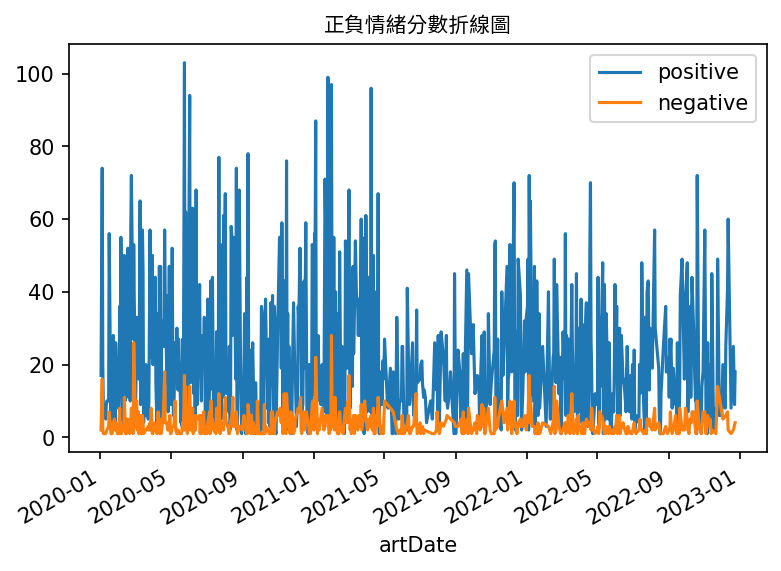

In [65]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

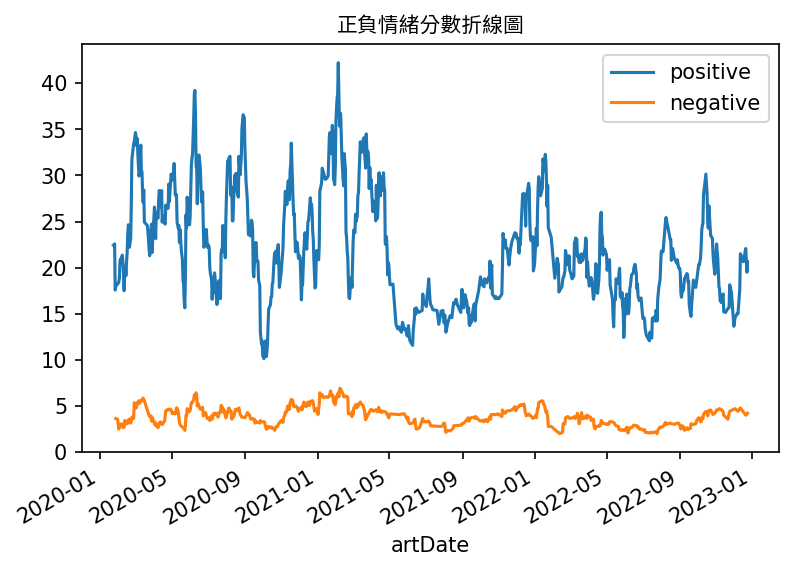

In [66]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的分數幾乎每天都超過負面，是個氣氛和諧的討論版。

### 3.4 正負向情緒分數比例折線圖圖

In [67]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2020-01-02,affect,20,0.512821
1,2020-01-02,negative,2,0.051282
2,2020-01-02,positive,17,0.435897
7,2020-01-04,positive,74,0.381443
6,2020-01-04,negative,16,0.082474
...,...,...,...,...
2758,2022-12-23,affect,10,0.526316
2761,2022-12-24,negative,4,0.088889
2762,2022-12-24,positive,18,0.400000
2760,2022-12-24,affect,23,0.511111


In [68]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

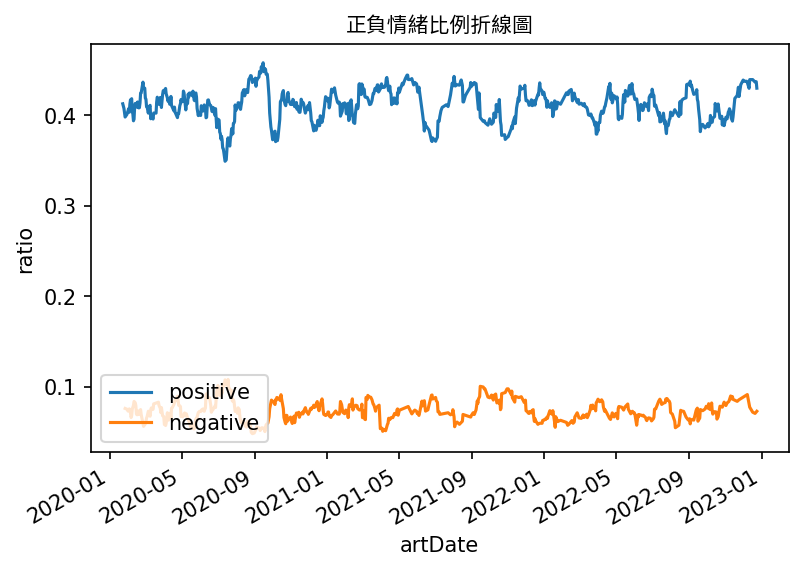

In [69]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [70]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
428,2020-05-24,positive,103,0.397683
1181,2021-01-25,positive,99,0.441964
1203,2021-01-31,positive,97,0.360595
1419,2021-04-09,positive,96,0.466019
456,2020-06-02,positive,94,0.417778


#### 2020-05-24 文字雲
2020-05-24 是正面詞彙次數最高的一天。我們可以用文字雲來觀察，美食版在這天最常出現的正面情緒字有哪些。

In [71]:
date = "2020-05-24"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


[('好吃', 34),
 ('不錯', 28),
 ('喜歡', 24),
 ('小菜', 22),
 ('口感', 21),
 ('吃到飽', 21),
 ('餐廳', 20),
 ('咖哩', 19),
 ('感覺', 18),
 ('新鮮', 18),
 ('海鮮', 18),
 ('時間', 17),
 ('蘇可泰', 17),
 ('選擇', 16),
 ('吃起來', 15),
 ('口味', 14),
 ('味道', 14),
 ('適合', 14),
 ('喜來登', 13),
 ('用餐', 13)]

(-0.5, 399.5, 199.5, -0.5)

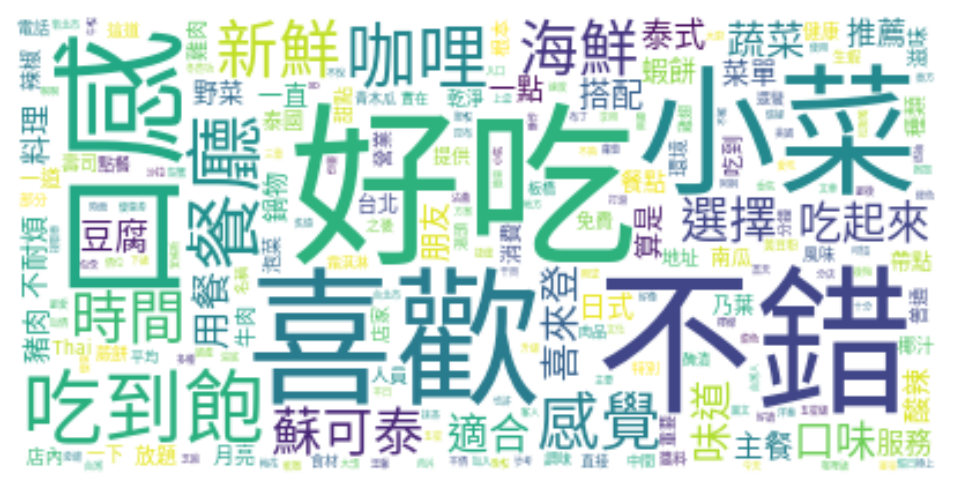

In [72]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

這天最主要可能是在討論喜來登大飯店的「蘇可泰」。同時也討論了不少餐點，像是海鮮、豆腐、咖哩，另外有一些食記通常會討論到的面向，例如口感、吃到飽、味道等等。

(-0.5, 399.5, 199.5, -0.5)

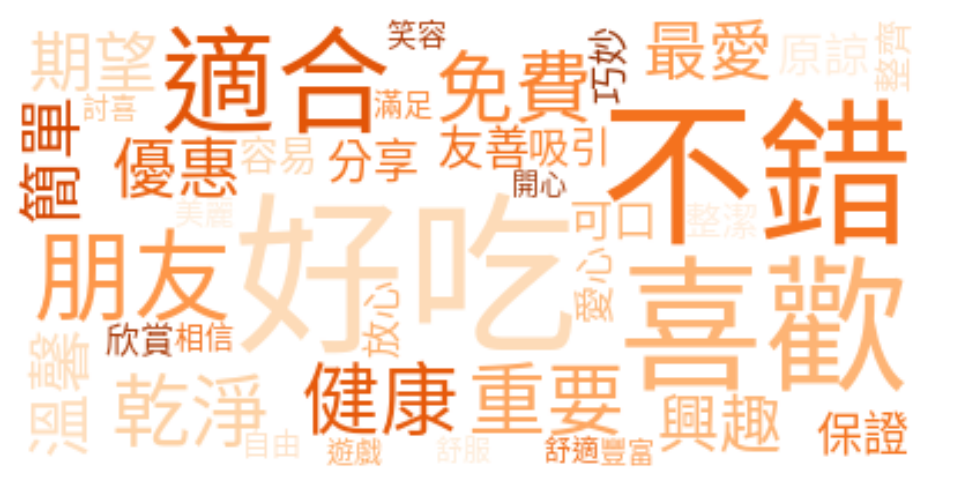

In [73]:
date = "2020-05-24"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

(-0.5, 399.5, 199.5, -0.5)

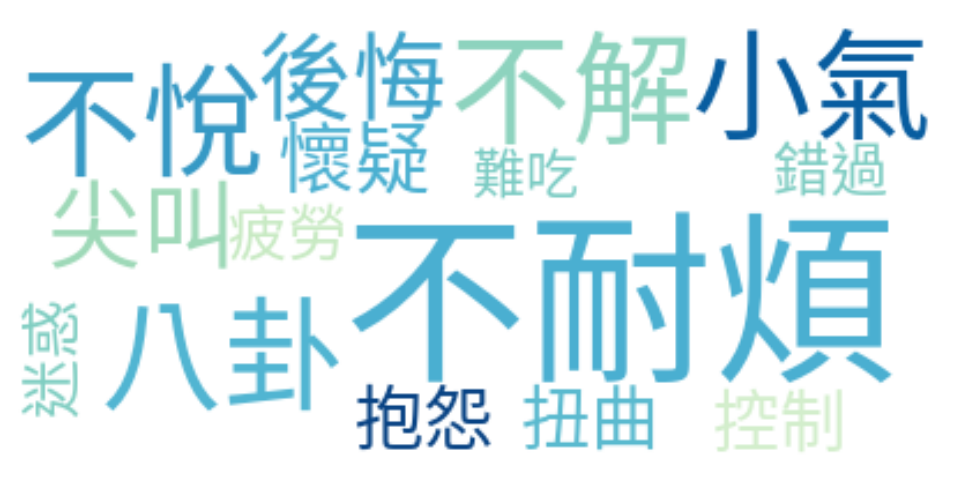

In [74]:
date = "2020-05-24"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [75]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
52,不錯,affect,2144
53,不錯,positive,2144
318,喜歡,positive,1718
317,喜歡,affect,1718
403,好吃,affect,1702
...,...,...,...
148,充沛,positive,1
147,充沛,affect,1
142,優越,affect,1
135,優於,positive,1


In [76]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

,word,sentiments,size
53,不錯,positive,2144
318,喜歡,positive,1718
404,好吃,positive,1702
801,朋友,positive,708
1366,適合,positive,693
...,...,...,...
892,深愛,positive,1
152,光輝,positive,1
150,光亮,positive,1
148,充沛,positive,1


In [77]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

,word,sentiments,size
304,問題,negative,201
728,擔心,negative,112
1395,錯過,negative,104
1425,隨便,negative,79
392,失望,negative,78
...,...,...,...
921,漫不經心,negative,1
951,無視,negative,1
955,煎熬,negative,1
898,混淆,negative,1


In [78]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

,word,sentiments,size
304,問題,negative,201
728,擔心,negative,112
1395,錯過,negative,104
1425,隨便,negative,79
392,失望,negative,78
...,...,...,...
212,勾引,negative,1
585,情緒,negative,1
579,悲劇,negative,1
39,不耐,negative,1


/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


Text(0.5, 1.0, '負向情緒總數')

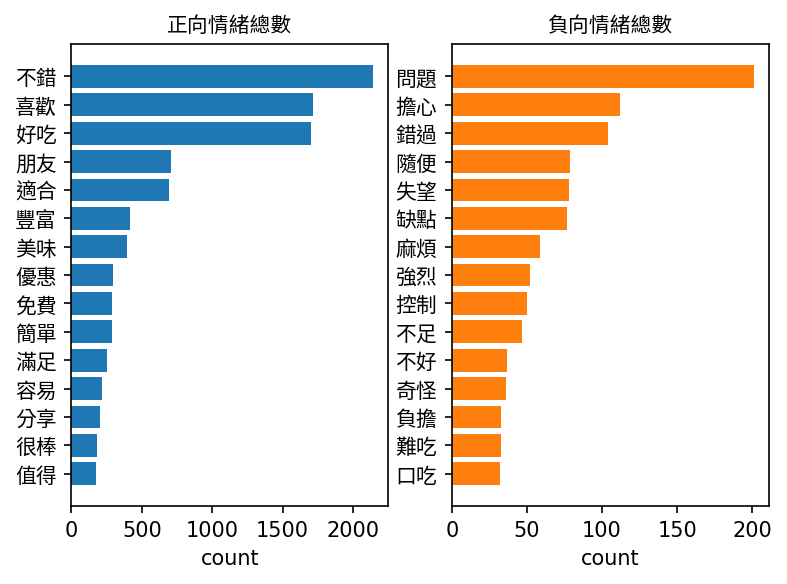

In [79]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

另外，也可以依據不同日期觀察情緒代表字的變化
#### 2021-01-31	 正負情緒代表字

In [80]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
1202,2021-01-31,negative,28,0.104089
163,2020-02-27,negative,26,0.150289
1129,2021-01-04,negative,22,0.089069
325,2020-04-20,negative,18,0.105263
427,2020-05-24,negative,17,0.065637
...,...,...,...,...
252,2020-03-30,negative,1,0.009434
2199,2022-04-09,negative,1,0.111111
2203,2022-04-10,negative,1,0.024390
1549,2021-06-04,negative,1,0.071429


In [81]:
date = '2021-01-31'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,sentiments,word,size
0,negative,不受,1
1,negative,不好,1
2,negative,傷害,1
3,negative,口吃,1
4,negative,可怕,1


/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


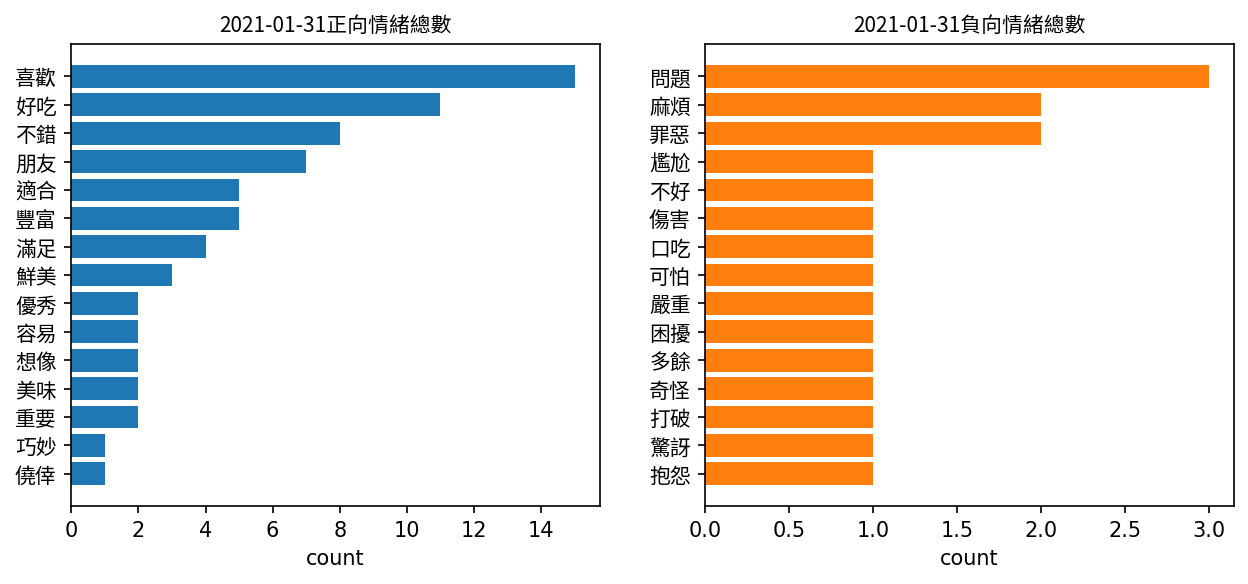

In [82]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數", fontproperties=fprop)
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數", fontproperties=fprop)
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
plt.show()

### 3.7 每日情緒分數趨勢

In [83]:
sentiment_count

,artDate,sentiments,size,ratio
0,2020-01-02,affect,20,0.512821
1,2020-01-02,negative,2,0.051282
2,2020-01-02,positive,17,0.435897
7,2020-01-04,positive,74,0.381443
6,2020-01-04,negative,16,0.082474
...,...,...,...,...
2758,2022-12-23,affect,10,0.526316
2761,2022-12-24,negative,4,0.088889
2762,2022-12-24,positive,18,0.400000
2760,2022-12-24,affect,23,0.511111


In [84]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2020-01-02,20,0,0,2,17,0
1,2020-01-04,97,2,3,16,74,2
2,2020-01-05,22,0,0,2,20,0
3,2020-01-06,10,0,0,1,8,1
4,2020-01-10,6,0,1,1,5,1


In [85]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2020-01-02,20,0,0,2,17,0,15
1,2020-01-04,97,2,3,16,74,2,51
2,2020-01-05,22,0,0,2,20,0,18
3,2020-01-06,10,0,0,1,8,1,6
4,2020-01-10,6,0,1,1,5,1,2


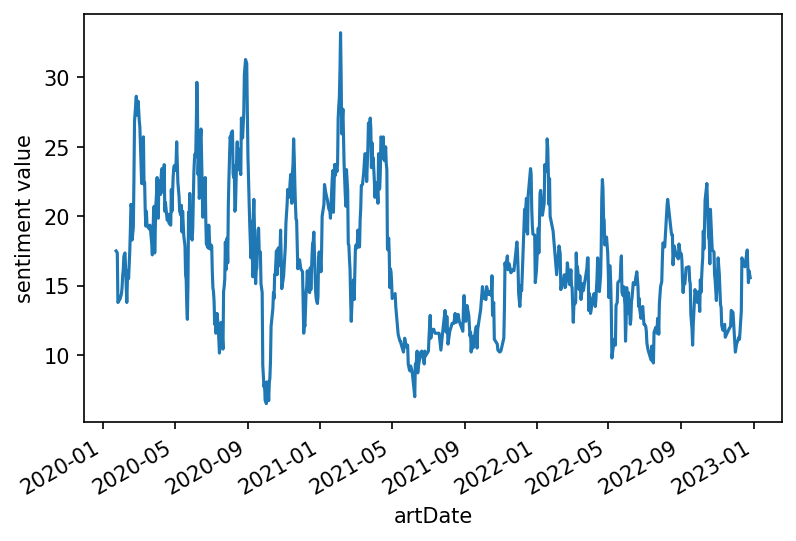

In [86]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()